In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import math
sys.path.append('../')
from Scattering_Simulator import pairwise_method
from Scattering_Simulator import Read_PDB
from scipy import integrate
import h5py
import plotly.express as px

c:\Users\htchi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Summary 
This notebook contains code used to create the RhuA tube like structures and to simulate the scattering curve of the structure. The coordinates of the RhuA protein is first loaded from its PDB file. The lattice coordinates are then found which represents where each building block coordinate will be translated and rotated. The scattering curve of the structure can then be calculated by creating the pairwise distribution and then converting it to the scattering intensity. This notebook uses the "convolution method" where the building block and lattice coordinates are independently sampled. Translational and rotational transformations are applied to the building block coordinates, which are then used to create the pairwise distribution. 

### Useful Functions
The following functions were used to create the helix and to rotate coordinates around the axes. 

In [2]:
def helix_coord(amp, f , low, high, n):
    '''This function is used to create the cooridnates of the helix'''
    y = np.linspace(low, high, n)
    x = amp*np.cos(f*y)
    z = amp*np.sin(f*y)
    return x, y, z

def relative_coordinates(volume):
    '''This function is used to center any set of coordinates at the origin'''
    rel_x = volume[:,0] - np.mean(volume[:,0])
    rel_y = volume[:,1] - np.mean(volume[:,1])
    rel_z = volume[:,2] - np.mean(volume[:,2])
    relative_volume = np.hstack((rel_x.reshape(-1,1), rel_y.reshape(-1,1), rel_z.reshape(-1,1), volume[:,-1].reshape(-1,1)))
    return relative_volume

def rotation_angle(x,z):
    '''This function converts cartesian coordinates to polar'''
    angle = -np.arctan2(z, x)*180/math.pi
    return np.round(angle)

def amp_Calculate(inner, outer):
    '''This is used to find the mean diameter from the inner and outer ones'''
    return (inner+outer)*10/2/2

def rotate_coordinates_y(x, z, angle):
    '''This function performs a rigid body rotation around the y-axis'''
    angle = angle*math.pi/180
    x_new = x*np.cos(angle) + z*np.sin(angle)
    z_new = -x*np.sin(angle) + z*np.cos(angle)
    return x_new, z_new

def rotate_coordinates_x(y, z, angle):
    '''This function performs a rigid body rotation around the x-axis'''
    angle = angle*math.pi/180
    y_new = y*np.cos(angle) + z*np.sin(angle)
    z_new = -y*np.sin(angle) + z*np.cos(angle)
    return y_new, z_new

def rotate_coordinates_z(x, y, angle):
    '''This function performs a rigid body rotation around the z-axis'''
    angle = angle*math.pi/180
    x_new = x*np.cos(angle) + y*np.sin(angle)
    y_new = -x*np.sin(angle) + y*np.cos(angle)
    return x_new, y_new

## Load the Coordinates of the Building Block
The coordinates of the building block is loaded from its PDB file. Scattering length densities are assigned to each atom. The protein is rotated to orient facing upwards using functions that rotate it around the x,y, and z axes. The position of each atom and the SLD is combined to form the building_block array.

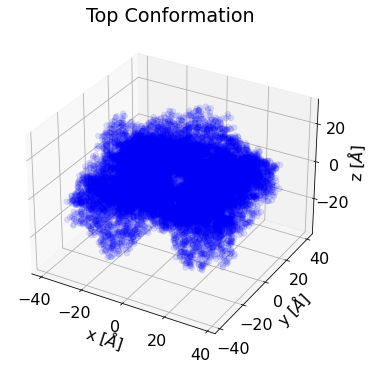

In [72]:
#coordinates = Read_PDB.load_pdb('../Data/PDB/RhuA/1ojr.pdb1') #this function loads the pdb file
coordinates = Read_PDB.load_pdb('../Data/PDB/RhuA/1gt7.pdb')
coordinates = relative_coordinates(coordinates)
volume = coordinates.copy()
#This rotates the protein around the specifed axis
coordinates[:,1], coordinates[:,2] = rotate_coordinates_x(coordinates[:,1], coordinates[:,2], 180)
coordinates = np.hstack((coordinates[:,0].reshape(-1,1), coordinates[:,2].reshape(-1,1), coordinates[:,1].reshape(-1,1), coordinates[:,-1].reshape(-1,1)))
coordinates[:,0], coordinates[:,1] = rotate_coordinates_z(coordinates[:,0], coordinates[:,1], 0)
volume_rotated = np.hstack((coordinates[:,0].reshape(-1,1), coordinates[:,2].reshape(-1,1), coordinates[:,1].reshape(-1,1), coordinates[:,-1].reshape(-1,1)))
coordinates[:,0], coordinates[:,2] = rotate_coordinates_y(coordinates[:,0], coordinates[:,2], 30)
volume_rotated = np.hstack((coordinates[:,0].reshape(-1,1), coordinates[:,2].reshape(-1,1), coordinates[:,1].reshape(-1,1), coordinates[:,-1].reshape(-1,1)))
coordinates = volume_rotated
# Plotting
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.scatter(volume_rotated[:,0],volume_rotated[:,1], color = 'blue', alpha = 0.1, s = 30)
ax.scatter(volume_rotated[:,0],volume_rotated[:,1],volume_rotated[:,2], color = 'blue', alpha = 0.1, s = 30)
ax.set_xlabel('x [$\AA$]')
ax.set_ylabel('y [$\AA$]')
ax.set_zlabel('z [$\AA$]')
ax.set_title('Top Conformation')
building_block = coordinates

## Lattice Coordinates 
The lattice coordinates are then created by using the mathematical equation of a helix. The lattice coordinates contain the positional and rotational transformations of each coordinate. To create a large biomolecular assembly, the building block is duplicated, translated, and rotated onto each lattice coordinate. 

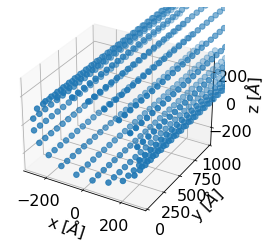

In [84]:
######### Parameters of Helix ############### 
OD = 62 #Outer diameter of the helix in units of nm
start = 21 #number of proteins in one full rotation of the tube 
full_rotations = 30 # Number of full rotations in the tube like structure. This will increase the length of the tube. 
low = 0

#################################################
amp = amp_Calculate(OD, OD-10) #Radius of tube/helix
high = full_rotations*80 # Length of Tube, Assuming that one circle is 80 A thick
n = int(start*full_rotations+1) # Number of Points in the helix
f = full_rotations*2*math.pi/high #frequency

x, y, z = helix_coord(amp, f, low, high, n)
plt.rcParams.update({'font.size': 16})
ax = plt.axes(projection='3d')
ax.scatter(x,y,z, s=30)
ax.set_xlabel('x [$\AA$]')
ax.set_ylabel('y [$\AA$]')
ax.set_zlabel('z [$\AA$]')
ax.set_ylim([0,1000])
#ax.set_axis_off()
#plt.savefig('../Figures/RhuA/Helix_Coordinates.png', dpi=300, bbox_inches="tight")
lattice_coordinates_position = np.hstack((x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1)))

The rotation of each lattice coordinate can be calculated by converting the coordinates of the helix to polar coordinates. This is the amount of rotation needed at each coordinate to align the proteins facing the center of the helix. Adjacent proteins are further rotated by 180 degrees to form an alternating checker-board like structure. 

In [85]:
beta = rotation_angle(x, z) + 90
beta[::2] = beta[::2] + 180
alpha = np.array([0]*len(beta))
gamma = np.array([0]*len(beta))

In [86]:
lattice_coordinates = np.hstack((lattice_coordinates_position, alpha.reshape(-1,1), beta.reshape(-1,1), gamma.reshape(-1,1)))

## Sample from the Building Block
The first step is to randomly sample coordinates from the building_block.

In [87]:
n_samples = 10000000

In [88]:
simulator = pairwise_method.scattering_simulator(n_samples)
simulator.sample_building_block(building_block)

## Sample from the Lattice
The second step is to randomly sample coordinates from the lattice_coordinates.

In [89]:
simulator.sample_lattice_coordinates(lattice_coordinates)

## Convolution of the Building Block and Lattice
A convolution can be performed where each randomly sampled coordinate from the building block undergoes a translational and rotational transformation according to the randomly sampled coordinate from the lattice_coordinate. 

In [90]:
simulator.calculate_structure_coordinates()

## Simulate the Scattering Curve
The scattering curve can be calculated from the pairwise distribution. This command simulates the scattering curve 10 times and takes the average of all the curves. 

In [95]:
histogram_bins = 10000
q = np.geomspace(0.004, 0.2, 6000)
I_q = simulator.simulate_multiple_scattering_curves_lattice_coords(building_block, lattice_coordinates, histogram_bins, q, save=False)
#I_q = simulator.simulate_scattering_curve_fast_lattice(building_block, lattice_coordinates, histogram_bins, q, save=False)

## Plot the Scattering Curve

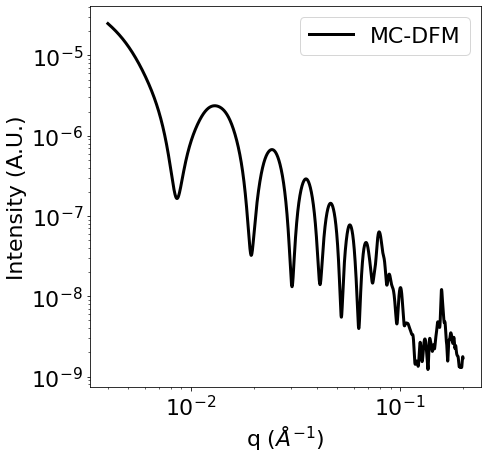

In [96]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(7,7))
background = 0
plt.plot(q, np.mean(I_q, axis=1) + background, linewidth = 3, label = 'MC-DFM', color='k')
#plt.plot(q, I_q + background, linewidth = 3, label = 'MC-DFM', color='k')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Intensity (A.U.)')
plt.xlabel('q ($\AA^{-1}$)')
ax.minorticks_on()
plt.legend(loc=1)
plt.show()
#plt.savefig('../Images/Comparison.png', dpi=300, bbox_inches="tight")
#data = np.hstack((q.reshape(-1,1), np.mean(I_q, axis=1).reshape(-1,1)))
#np.save('../Data/simulated_scattering/RhuA_3/RhuA_' + str(amp) + '_amp_' + str(start) + '_start_' + str(OD) + 'nm_OD.npy', data)

## Plot the Pairwise Distribution

Text(0.5, 0, 'Interatomic Distance ($\\AA$)')

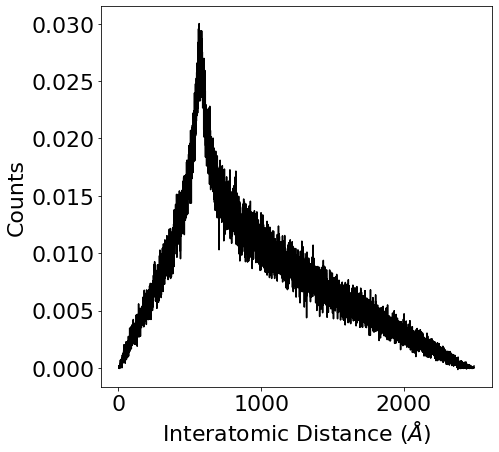

In [97]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(simulator.r, simulator.p_r*1e6, color='k')
plt.ylabel('Counts')
plt.xlabel('Interatomic Distance ($\AA$)')
#plt.savefig('../Images/RhuA/pairwise_dist_tubes.png', dpi=300, bbox_inches="tight")

To confirm which object the scattering curve belongs to, we can plot the randomly sampled coordiantes used to create the pairwise distribution. As expected, the object is the tube like structure made from assembling the RhuA protein. 

Text(0, 0.5, 'z axis [$\\AA$]')

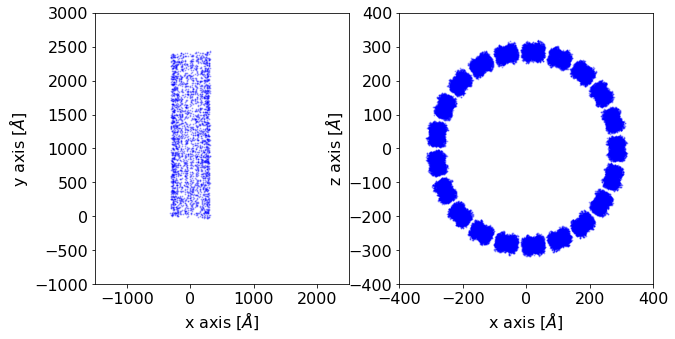

In [98]:
struc = simulator.structure_coordinates_1
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10,5), ncols=2, nrows=1)
ax[0].scatter(struc[:,0][::200], struc[:,1][::200], alpha = 0.25, s=1, color = 'blue')
ax[0].set_xlim([-1500,2500])
ax[0].set_ylim([-1000,3000])
ax[0].set_xlabel('x axis [$\AA$]')
ax[0].set_ylabel('y axis [$\AA$]')
ax[1].scatter(struc[:,0][::10], struc[:,2][::10], alpha = 0.25, s=1, color = 'blue')
ax[1].set_xlim([-400,400])
ax[1].set_ylim([-400,400])
ax[1].set_xlabel('x axis [$\AA$]')
ax[1].set_ylabel('z axis [$\AA$]')

#plt.savefig('../Images/Sampled_Electron_Density_Tube_assembly_2.png', dpi=300, bbox_inches="tight")